In [31]:
# Import necessary libraries
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.optim import AdamW
from sentence_transformers import SentenceTransformer, util
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Suppress the specific FutureWarning from huggingface_hub
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub.file_download")


In [33]:
# Load the probes dataset
probes_df = pd.read_csv("../data/Catalog - Probes.csv")
probes_df = probes_df.drop(['Description'], axis=1)

# Split "Compatible_Systems" column
probes_df['Compatible_Systems'] = probes_df['Compatible_Systems'].str.split(', ')

# Split "Applications" column
probes_df['Applications'] = probes_df['Applications'].str.split(', ')

# Load the systems dataset
systems_df = pd.read_csv("../data/systems.csv")

# Split "compatible_probes" column
systems_df['compatible_probes'] = systems_df['compatible_probes'].str.split(', ')

# Print the head of the dataframes
probes_df.head()

,Manufacturer,Probe_Model,Cartridge_Connection,Compatible_Systems,Array_Type,Applications,Min_Frequency,Max_Frequency,Stock
0,ATL,C3,0,[HDI 5000],convex,"[abdominal, general]",3.0,3.0,0
1,ATL,C4-2,0,[HDI 5000],convex,"[abdominal, obstetric, gynecologic, general]",2.0,4.0,2
2,ATL,C5-2,0,"[HDI 1500, HDI 3000, HDI 3500, HDI 5000]",convex,"[abdominal, general]",2.0,5.0,7
3,ATL,C5-IVT,0,"[UM9 HDI, HDI 1500, HDI 3000, HDI 3500, HDI 5000]",convex,"[intracavitary, endovaginal, gynecological]",4.0,6.0,0
4,ATL,C7-4,0,"[UM9 HDI, HDI 1500, HDI 3000, HDI 5000]",convex,"[cardiac, vascular, general]",4.0,7.0,0


In [34]:
systems_df.head()

,ultrasound_system,manufacturer,compatible_probes
0,HDI 5000,ATL,"[C3, C4-2, C5-2, C5-IVT, C7-4, C8-4v, C9-5ICT,..."
1,HDI 1500,ATL,"[C5-2, C5-IVT, C7-4, C9-5ICT, L7-4]"
2,HDI 3000,ATL,"[C5-2, C5-IVT, C7-4, C8-4v, CL 10-5, CT8-4, L7-4]"
3,HDI 3500,ATL,"[C5-2, C5-IVT, C8-4v, CT8-4]"
4,UM9 HDI,ATL,"[C5-IVT, C7-4, L7-4]"


In [35]:
# Function to generate probe descriptions, questions, answers, and relevant documents
def generate_probe_info(row):
    """
    This function takes a row from the probes_df DataFrame and generates lists of probe descriptions, questions, answers, relevant documents, and tags.
    """
    descriptions = []
    questions = []
    answers = []
    relevant_documents = []
    tags = []

    # Manufacturer
    descriptions.append(f"The manufacturer of the {row['Probe_Model']} probe is {row['Manufacturer']}.")
    questions.append(f"Who is the manufacturer of the {row['Probe_Model']} probe?")
    answers.append(row['Manufacturer'])
    relevant_documents.append(f"The manufacturer of the {row['Probe_Model']} probe is {row['Manufacturer']}.")
    tags.append(['probes', 'manufacturer', row['Manufacturer'], row['Probe_Model']])

    # Cartridge Connection
    if row['Cartridge_Connection'] == 1:
        questions.append(f"Does the {row['Manufacturer']} {row['Probe_Model']} have a cartridge connector?")
        descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe has a variant with a cartridge connection.")
        relevant_documents.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe has a variant with a cartridge connection.")
        answers.append(row['Cartridge_Connection'])
        tags.append(['probes', row['Manufacturer'], row['Probe_Model'], 'connection'])

    # Compatible Systems
    compatible_systems = ', '.join(row['Compatible_Systems'])
    descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is compatible with the following systems: {compatible_systems}.")
    questions.append(f"Which systems is the {row['Probe_Model']} probe compatible with?")
    answers.append(compatible_systems)
    relevant_documents.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is compatible with the following systems: {compatible_systems}.")
    tags.append(['probes', row['Manufacturer'], row['Probe_Model'], 'compatibility', compatible_systems])

    # Array Type
    descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} is a {row['Array_Type']} array type probe.")
    questions.append(f"What is the array type of the {row['Probe_Model']} probe?")
    answers.append(row['Array_Type'])
    relevant_documents.append(f"The {row['Manufacturer']} {row['Probe_Model']} is a {row['Array_Type']} array type probe.")
    tags.append(['probes', row['Manufacturer'], row['Probe_Model'], 'array type'])

    # Applications
    applications = ', '.join(row['Applications'])
    descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is suitable for the following applications: {applications}.")
    questions.append(f"Which applications is the {row['Probe_Model']} probe suitable for?")
    answers.append(applications)
    relevant_documents.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is suitable for the following applications: {applications}.")
    tags.append(['probes', row['Manufacturer'], row['Probe_Model'], "applications", applications])

    # Stock
    if row['Stock'] > 0:
        descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is currently in stock and available for sale.")
    else:
        descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is currently out of stock or not available for sale.")
    questions.append(f"Do you have any {row['Probe_Model']} probes for sale?")
    answers.append(row['Stock'])
    relevant_documents.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is currently {'in stock and available for sale' if row['Stock'] > 0 else 'out of stock or not available for sale'}.")
    tags.append(['probes', row['Manufacturer'], row['Probe_Model'], 'stock'])

    # Frequency Range
    descriptions.append(f"The frequency range of the {row['Manufacturer']} {row['Probe_Model']} probe is {row['Min_Frequency']} - {row['Max_Frequency']} MHz.")
    questions.append(f"What is the frequency range of the {row['Probe_Model']} probe?")
    answers.append(f"{row['Min_Frequency']} - {row['Max_Frequency']} MHz")
    relevant_documents.append(f"The frequency range of the {row['Manufacturer']} {row['Probe_Model']} probe is {row['Min_Frequency']} - {row['Max_Frequency']} MHz.")
    tags.append(['probes', row['Manufacturer'], row['Probe_Model'], 'frequency'])

    return descriptions, questions, answers, relevant_documents, tags

def generate_system_description(row):
    """
    This function takes a row from the systems_df DataFrame and generates lists of system descriptions, questions, answers, relevant documents, and tags.
    """
    descriptions = []
    questions = []
    answers = []
    relevant_documents = []
    tags = []

    # System manufacturer
    description = f"The {row['ultrasound_system']} ultrasound system is made by {row['manufacturer']}."
    descriptions.append(description)
    questions.append(f"Who is the manufacturer of the {row['ultrasound_system']} ultrasound system?")
    answers.append(row['manufacturer'])
    relevant_documents.append(description)
    tags.append([row['manufacturer'], row['ultrasound_system'], 'manufacturer', 'systems'])

    # System compatible probes
    compatible_probes = ', '.join(row['compatible_probes'])
    description = f"The {row['manufacturer']} {row['ultrasound_system']} ultrasound system is compatible with the following probes: {compatible_probes}."
    descriptions.append(description)
    questions.append(f"Which probes is the {row['manufacturer']} {row['ultrasound_system']} ultrasound system compatible with?")
    answers.append(compatible_probes)
    relevant_documents.append(description)
    tags.append([row['manufacturer'], row['ultrasound_system'], 'compatibility', 'systems', compatible_probes])

    return descriptions, questions, answers, relevant_documents, tags

# Apply the probe function and directly unpack into separate lists
probe_descriptions, probe_questions, probe_answers, probe_relevant_documents, probe_tags = zip(*probes_df.apply(generate_probe_info, axis=1))

# Apply the system function and directly unpack into separate lists
system_descriptions, system_questions, system_answers, system_relevant_documents, system_tags = zip(*systems_df.apply(generate_system_description, axis=1))

# Flatten the lists since each element is a list of items
all_contents = [item for sublist in (probe_descriptions + system_descriptions) for item in sublist]
all_questions = [item for sublist in (probe_questions + system_questions) for item in sublist]
all_answers = [item for sublist in (probe_answers + system_answers) for item in sublist]
all_relevant_documents = [item for sublist in (probe_relevant_documents + system_relevant_documents) for item in sublist]
all_tags = [item for sublist in (probe_tags + system_tags) for item in sublist]

# Create a DataFrame from these lists
documents_df = pd.DataFrame({
    'content': all_contents,
    'questions': all_questions,
    'relevant_documents': all_relevant_documents,
    'short_answers': all_answers,
    'tags': all_tags
})

documents_df.head()

,content,questions,relevant_documents,short_answers,tags
0,The manufacturer of the C3 probe is ATL.,Who is the manufacturer of the C3 probe?,The manufacturer of the C3 probe is ATL.,ATL,"[probes, manufacturer, ATL, C3]"
1,The ATL C3 probe is compatible with the follow...,Which systems is the C3 probe compatible with?,The ATL C3 probe is compatible with the follow...,HDI 5000,"[probes, ATL, C3, compatibility, HDI 5000]"
2,The ATL C3 is a convex array type probe.,What is the array type of the C3 probe?,The ATL C3 is a convex array type probe.,convex,"[probes, ATL, C3, array type]"
3,The ATL C3 probe is suitable for the following...,Which applications is the C3 probe suitable for?,The ATL C3 probe is suitable for the following...,"abdominal, general","[probes, ATL, C3, applications, abdominal, gen..."
4,The ATL C3 probe is currently out of stock or ...,Do you have any C3 probes for sale?,The ATL C3 probe is currently out of stock or ...,0,"[probes, ATL, C3, stock]"


In [36]:
# Load the models
models = {
    'multi-qa-mpnet-base-dot-v1': SentenceTransformer('multi-qa-mpnet-base-dot-v1'),
    'all-mpnet-base-v2': SentenceTransformer('all-mpnet-base-v2'),
    'multi-qa-distilbert-cos-v1': SentenceTransformer('multi-qa-distilbert-cos-v1')
}

# Generate embeddings for the content and questions
embeddings = {}
for model_name, model in models.items():
    embeddings[model_name] = {
        'content': model.encode(documents_df['content'].tolist(), convert_to_tensor=True, show_progress_bar=True),
        'questions': model.encode(documents_df['questions'].tolist(), convert_to_tensor=True, show_progress_bar=True)
    }

You try to use a model that was created with version 3.0.0.dev0, however, your version is 3.0.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [45]:
def compute_rr(embeddings, ranking_method):
    results_df = documents_df.copy()
    results_df['absolute_rank'] = 0
    results_df['rr'] = 0.0

    for i, question in enumerate(documents_df['questions']):
        relevant_doc = documents_df['relevant_documents'].iloc[i]
        query_emb = embeddings['questions'][i].unsqueeze(0)  # Add batch dimension

        if ranking_method == 'dot_score':
            scores = util.dot_score(query_emb, embeddings['content'])[0].cpu().tolist()
        elif ranking_method == 'cos_sim':
            scores = util.cos_sim(query_emb, embeddings['content'])[0].cpu().tolist()

        # Combine docs & scores
        doc_score_pairs = list(zip(documents_df['content'], scores))

        # Sort by decreasing score
        doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

        # Find the rank of the first relevant document
        matching_indices = [idx for idx, (doc, score) in enumerate(doc_score_pairs) if doc == relevant_doc]
        if len(matching_indices) > 0:
            rank = matching_indices[0] + 1
        else:
            rank = len(doc_score_pairs) + 1  # Relevant document not found

        # Calculate reciprocal rank
        rr = 1 / rank

        # Update the corresponding row in results_df
        results_df.at[i, 'absolute_rank'] = rank
        results_df.at[i, 'rr'] = rr

    return results_df

# Compute RR for each model and ranking method
results = {
    'multi-qa-mpnet-base-dot-v1': compute_rr(embeddings['multi-qa-mpnet-base-dot-v1'], 'dot_score'),
    'all-mpnet-base-v2': compute_rr(embeddings['all-mpnet-base-v2'], 'dot_score'),
    'multi-qa-distilbert-cos-v1': compute_rr(embeddings['multi-qa-distilbert-cos-v1'], 'cos_sim')
}

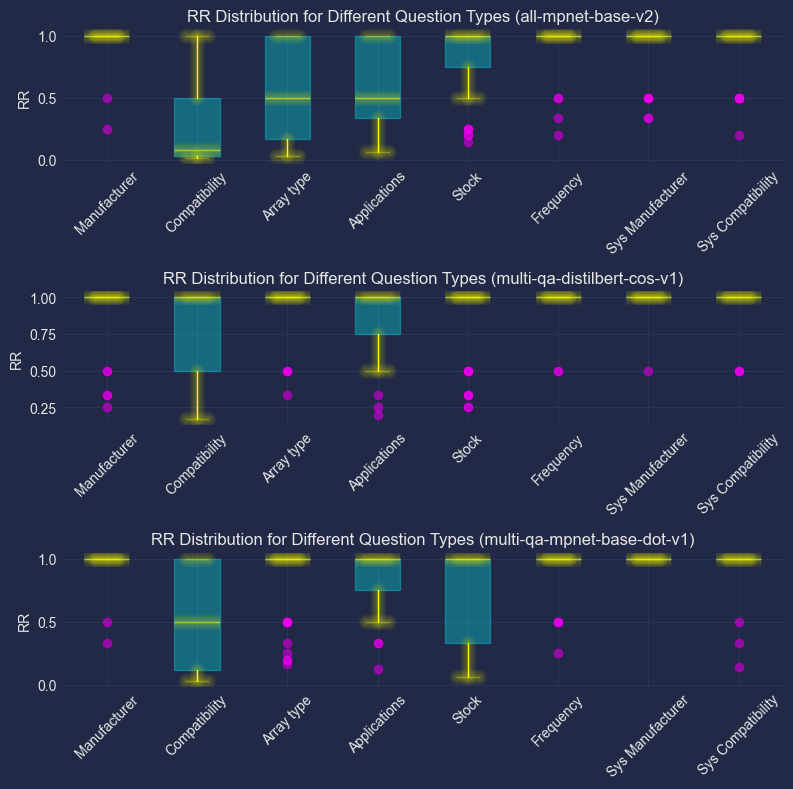

In [102]:
import mplcyberpunk

# Set the style to cyberpunk
plt.style.use("cyberpunk")

# Define the order of models
model_order = ['all-mpnet-base-v2', 'multi-qa-distilbert-cos-v1', 'multi-qa-mpnet-base-dot-v1']

# Filter RR values for different 'probes' and 'systems' question types
probe_types = ['manufacturer', 'compatibility', 'array type', 'applications', 'stock', 'frequency']
system_types = ['manufacturer', 'compatibility']

results_rr_by_type = {key: {ptype: df[df['tags'].apply(lambda x: 'probes' in x and ptype in x)]['rr'].dropna() for ptype in probe_types} for key, df in results.items()}

# Add 'systems' question types to the results
for key, df in results.items():
    results_rr_by_type[key].update({f'systems_{stype}': df[df['tags'].apply(lambda x: 'systems' in x and stype in x)]['rr'].dropna() for stype in system_types})

# Define the complete list of question types in the desired order
all_types = probe_types + [f'systems_{stype}' for stype in system_types]
labels = [ptype.capitalize() for ptype in probe_types] + [f'Sys {stype.capitalize()}' for stype in system_types]

# Create the boxplot
fig, ax = plt.subplots(len(model_order), 1, figsize=(8, 8))  # Adjust the figure size

for i, model_key in enumerate(model_order):
    rr_by_type = results_rr_by_type[model_key]
    data = [rr_by_type[ptype] for ptype in all_types if ptype in rr_by_type]
    box = ax[i].boxplot(data, vert=True, patch_artist=True, medianprops=dict(color='yellow', alpha=0.5), boxprops=dict(facecolor='cyan', alpha=0.3, edgecolor='cyan'), capprops=dict(color='yellow', alpha=0.3), whiskerprops=dict(color='yellow'), flierprops=dict(markeredgecolor='magenta', markerfacecolor='magenta', alpha=0.3))
    ax[i].set_xticklabels(labels, rotation=45)
    ax[i].set_ylabel('RR')
    ax[i].set_title(f'RR Distribution for Different Question Types ({model_key})')

    mplcyberpunk.make_lines_glow(ax[i])

plt.tight_layout()
plt.savefig('../images/boxplot.png', dpi=96, bbox_inches='tight')
plt.show()

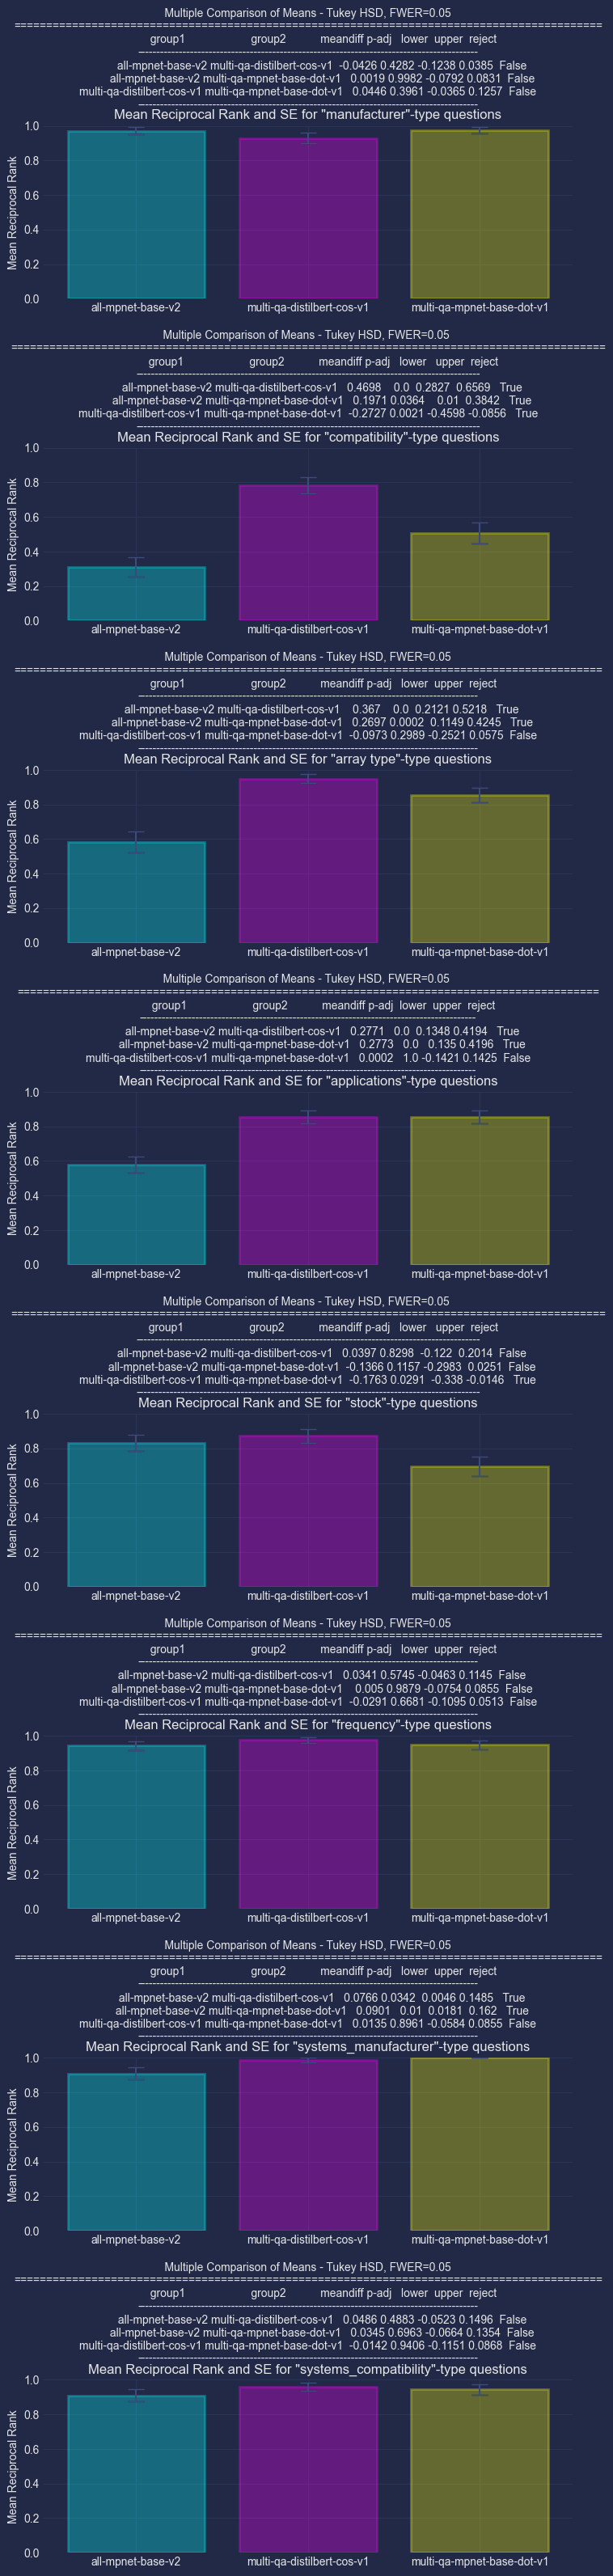

In [101]:
# Calculate means and standard errors
mean_rr_by_type = {}
se_rr_by_type = {}
tukey_results = {}

for ptype in all_types:
    mean_rr_by_type[ptype] = []
    se_rr_by_type[ptype] = []
    tukey_data = []
    for model_name in model_order:  # Use the defined model order
        rr_by_type = results_rr_by_type[model_name][ptype]
        mean_rr = np.mean(rr_by_type)
        se_rr = np.std(rr_by_type) / np.sqrt(len(rr_by_type))  # Standard Error of the mean
        mean_rr_by_type[ptype].append(mean_rr)
        se_rr_by_type[ptype].append(se_rr)
        tukey_data.extend([(ptype, model_name, rr) for rr in rr_by_type])

    # Prepare data for Tukey's HSD test
    tukey_df = pd.DataFrame(tukey_data, columns=['QuestionType', 'Model', 'RR'])
    tukey_result = pairwise_tukeyhsd(endog=tukey_df['RR'],
                                     groups=tukey_df['Model'],
                                     alpha=0.05)
    tukey_results[ptype] = tukey_result

# Colors for different models
colors = ['cyan', 'magenta', 'yellow']

fig, axes = plt.subplots(nrows=len(all_types), figsize=(8, 4 * len(all_types)))

if len(all_types) == 1:
    axes = [axes]

for ax, ptype in zip(axes, all_types):
    # Data for plotting
    means = mean_rr_by_type[ptype]
    errors = se_rr_by_type[ptype]
    x = np.arange(len(means))

    # Creating bar chart
    bars = ax.bar(x, means, yerr=errors, color=colors, capsize=7, alpha=0.3, linewidth=2, ecolor='#3C4B79')
    for bar, color in zip(bars, colors):
        bar.set_edgecolor(color)
    ax.set_xticks(x)
    ax.set_xticklabels(model_order)
    ax.set_title(f'Mean Reciprocal Rank and SE for "{ptype}"-type questions')
    ax.set_ylim(0, 1)
    ax.set_ylabel('Mean Reciprocal Rank')
    ax.set_yticks(np.linspace(0, 1, 6))

    # Add cyberpunk-style effects
    mplcyberpunk.make_lines_glow(ax, alpha_line=0.6)

    # Print Tukey's HSD results above the bar chart
    ax.text(0.5, 1.1, str(tukey_results[ptype]), transform=ax.transAxes, ha='center')

plt.tight_layout()
plt.savefig('../images/bar_chart.png', dpi=96, bbox_inches='tight')
plt.show()

In [26]:
class QADataset(Dataset):
    def __init__(self, question_embeddings, document_embeddings):
        self.question_embeddings = question_embeddings
        self.document_embeddings = document_embeddings

    def __len__(self):
        return len(self.question_embeddings)

    def __getitem__(self, idx):
        question_emb = self.question_embeddings[idx]
        document_emb = self.document_embeddings[idx]
        return question_emb, document_emb

In [32]:
question_embeddings = embeddings['multi-qa-distilbert-cos-v1']['questions']
content_embeddings = embeddings['multi-qa-distilbert-cos-v1']['content']

# Splitting the data into train and temporary set (for further splitting into validation and test)
questions_train, questions_temp, content_train, content_temp = train_test_split(
    question_embeddings, content_embeddings, test_size=0.2, random_state=42)

# Splitting the temporary set into validation and test sets
questions_val, questions_test, content_val, content_test = train_test_split(
    questions_temp, content_temp, test_size=0.5, random_state=42)

# Create Dataset Instances
train_dataset = QADataset(questions_train, content_train)
val_dataset = QADataset(questions_val, content_val)
test_dataset = QADataset(questions_test, content_test)

# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
model = YourModel()
num_epochs = 5
optimizer = AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()  # or another appropriate loss function

# Training loop
model.train()
for epoch in range(num_epochs):
    for questions, contents in train_loader:
        optimizer.zero_grad()
        outputs = model(questions, contents)
        loss = criterion(outputs, target)  # Define your target appropriately
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')